In [1]:
import pyro
import pandas as pd
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro_mixture_model import MixtureModel, MixtureModelGuide
from Preprocess_data import create_summed_df
from utils import split_patient_level, summarize_columns
# set random seed for reproducibility
np.random.seed(42)

c:\Users\marie\miniconda3\envs\mbml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and prepare it

In [2]:
if not os.path.exists("data/CaseRigshospitalet_summed.parquet"):
    print("Creating data file")
    create_summed_df()
print("Loading data file")
df = pd.read_parquet("data/CaseRigshospitalet_summed.parquet")

summarize_columns(df)

Loading data file
                           name     dtype  unique  size (MB)
0                    Patient ID  category  331647         30
1           Aktionsdiagnosekode  category    8167          1
2  totalDiagnoseKontaktVarighed   float32    8160          1
3                antalKontakter     int64     141          3
4                antalDiagnoser     int64      17          3
5                         alder   Float64   14014          4
6                        gender  category       4          0
7                    civilStand    object       4         29
8          distanceToHospitalKM   float64    1772          3
Total size (excluding "embedding"): 79.51814460754395 MB


### Create train and test data split

In [ ]:
(x_emb_train, d_demo_train, v_time_train, a_count_train), (x_emb_test, d_demo_test, v_time_test, a_count_test) = split_patient_level(df, total_samples=100000)

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


## Train

**Generative Process:**

1) Draw $\theta \sim \text{Dirichlet}(\alpha)$

2) For each group, $g$, in $G$:

    2a) Draw $\beta_g \sim \mathcal{N}(0,\bm{I}_K)$

    2b) Draw $\eta_g \sim \mathcal{N}(0,\bm{I}_K)$

    2c) Draw $\sigma_g \sim \text{HalfCauchy}(5)$

3) For each patient, $p$, in patients:

    3a) Draw group assignment $\bm{g}_p \sim \text{Categorical}(\theta)$

    3b) $\tilde{\mu} = \beta_{0}^g + \bm{\beta}_x^g \bm{x}_p + \bm{\beta}_d^g \bm{d}_p$
    
    3c) $\tilde{\lambda} = \exp (\gamma_{0}^g + \bm{\gamma}_x^g \bm{x}_p + \bm{\gamma}_d^g \bm{d}_p)$
    
    3d) Draw $\bm{v}_p \sim \text{LogNormal}(\tilde{\mu}, \sigma_{g_p})$ 
    
    3e) Draw $\bm{c}_p \sim \text{Poisson}(\tilde{\lambda})$ 

In [4]:
pyro.set_rng_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)

x_emb_train = x_emb_train.to(device)
d_demo_train = d_demo_train.to(device)
v_time_train  = v_time_train.to(device)
a_count_train = a_count_train.to(device)

G=10

# Setup SVI
optimizer = ClippedAdam({"lr": 1e-4})
svi = SVI(MixtureModel, MixtureModelGuide, optimizer, loss=Trace_ELBO())
losses = []

# Example training loop
def train(num_steps=1000):
    for step in range(num_steps):
        loss = svi.step(x_emb_train, d_demo_train, v_time_train, a_count_train, G, device)
        losses.append(loss)
        
        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

# To run:
train(1000)  # adjust steps
# After training, inspect pyro.param values for cluster parameters and q_alpha

# 9 minutes on GPU, 1000 samples, 10000 steps
# 4 minutes on GPU, 100000 samples, 1000 steps

Using device: cuda
Step 0 : loss = 81114305182.22548
Step 100 : loss = 2663821665489.7114
Step 200 : loss = 1158669976064.5598
Step 300 : loss = 207717072350.92026
Step 400 : loss = 6847088316442.33
Step 500 : loss = 42054689841.45674
Step 600 : loss = 72678147698.17749
Step 700 : loss = 18026707459.976974
Step 800 : loss = 315622305661.86273
Step 900 : loss = 58683156615.48846


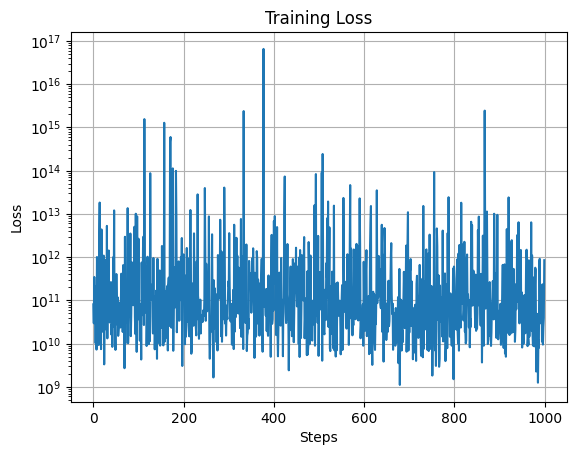

In [5]:
# plot loss
import matplotlib.pyplot as plt
def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.yscale("log")
    plt.grid()
    plt.show()

# Call the function to plot loss
plot_loss(losses)

In [6]:
# Plot predictions on test set
x_emb_test = x_emb_test.to(device).to(torch.float64)
d_demo_test = d_demo_test.to(device).to(torch.float64)
v_time_test = v_time_test.to(device).to(torch.float64)
a_count_test = a_count_test.to(device).to(torch.float64)

predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,                      # number of posterior draws
    return_sites=["obs_time", "obs_visits"]
)

# 3. Draw posterior‐predictive samples
samples = predictive(x_emb_test, d_demo_test, None, None, device)

# 4. Compute the posterior mean prediction for each outcome
pred_time   = samples["obs_time"].mean(dim=0).cpu().numpy()
pred_visits = samples["obs_visits"].mean(dim=0).cpu().numpy()

# 5. Get the “true” values
true_time   = v_time_test.cpu().numpy()
true_visits = a_count_test.cpu().numpy()

# 6. Plot True vs Predicted for time
plt.figure()
plt.scatter(true_time, pred_time)
plt.plot([true_time.min(), true_time.max()],
         [true_time.min(), true_time.max()],
         linewidth=1)
plt.xlabel("True Time Spent")
plt.ylabel("Predicted Time Spent")
plt.title("True vs Predicted Time Spent")

# 7. Plot True vs Predicted for visits
plt.figure()
plt.scatter(true_visits, pred_visits)
plt.plot([true_visits.min(), true_visits.max()],
         [true_visits.min(), true_visits.max()],
         linewidth=1)
plt.xlabel("True # Visits")
plt.ylabel("Predicted # Visits")
plt.title("True vs Predicted Number of Visits")

plt.show()

TypeError: ones() received an invalid combination of arguments - got (torch.device, device=str, dtype=torch.dtype), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
